# Milestone 3 - Independent Project
Version: Jun-2019

## Author - Lukas Fiorio

# Abstract

## Problem

Problem Statement: We need to understand the value of a home's features and attributes on its overall value

First, we visually examined the relationship between a home's sale price and its features to build our understanding.  Then, we applie statistical analysis and hypothesis testing to identify likely distributions and confidence intervals for our features. 

In this module, we build a predictive model based on these relationships.

## Conclusion

Many features had predictive power in determining a home's sale price.

We were able to achieve an R-squared of ~0.70 on our test data.  After binarizing the data, we were able to classify with overall accuracy of ~80%.

# Analysis

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from scipy.stats import mstats
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [2]:
# set package options
pd.set_option('display.max_columns', None) # show all columns
plt.rc('patch', force_edgecolor = True) # set bar borders in bar plots

Start by loading the data and reading it info a dataframe

In [3]:
# Locate & load dataset
file = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/kc_house_data.csv"
kc_homes = pd.read_csv(file) # read file into df

### Explore the dataset

| Field | Description | Units |
| :- | :- | :- |
| id | unique identifier for each property | |
| date | date sold | day |
| price | sale price | $ |
| bedrooms | number of bedrooms | # count |
| bathrooms | number of bathrooms | # count |
| sqft_living | size of living area | # square feet |
| sqft_lot | size of lot | # square feet |
| floors | number of floors | # count |
| waterfront | indicates whether property overlooks a waterfront | 0, 1 |
| view | quality of the property's view | index: 0 to 4 (poor to excellent) |
| condition | condition of the house | index: 1 to 5 (poor to excellent) |
| grade | construction quality, based on quality of materials/workmanship | index: 1 to 13 (poor to excellent) |
| sqft_above | size of living area - above ground | # square feet |
| sqft_basement | size of living area - below ground | # square feet |
| yr_built | year built | year |
| yr_renovated | year renovated | year (0 if never renovated) |
| zipcode | 5 digit zip code | |
| lat | latitude coordinates | |
| long | longitude coordinates | |
| sqft_living15 | nearest 15 properties: average size of living area | # square feet |
| sqft_lot15 | nearest 15 properties: average size of lot (square feet) | # square feet |

sources: 
- [King County Residential Glossary](https://blue.kingcounty.com/assessor/erealproperty/ResidentialGlossary.aspx)
- [GeoDa Data and Lab: King County House Sales](https://geodacenter.github.io/data-and-lab//KingCounty-HouseSales2015/)

## Data Exploration

In Milestone 2, we took several steps to explore our data and clean up issues we uncovered. For brevity, those data exploration steps are omitted here (but can be found in Milestone 2).

Of note, we noticed:
- A few records with 0 bedrooms and 0 bathrooms
- A record with 33 bedrooms (inferred to be 3 bedrooms)
- Some features that should be treated for outliers
- The date field stored as an object

### Specifically, we decided to treat outliers in our most susceptible feature columns

- `sqft_living`
- `sqft_lot`
- `sqft_above`
- `sqft_basement` 
- `sqft_living15`
- `sqft_lot15`

In [4]:
# columns to inspect
outlier_cols = [
    'sqft_living', 'sqft_lot',
    'sqft_above', 'sqft_basement', 
    'sqft_living15', 'sqft_lot15'
    ]

#### based on our explorating plots, we winsorize each of these columns by capping at the 99th percentile

- `price` itself may also have outliers, but we will leave as is for now
- noted that `sqft_living` will now no longer match `SUM(sqft_above, sqft_basement)`

In [5]:
# cap outliers at 99th percentile
for col in kc_homes[outlier_cols]:
    kc_homes[col] = mstats.winsorize(kc_homes[col], limits=[0.00, 0.01])

#### Next, we take the remaining data cleaning steps for issues we mentioned above

- drop 0 bed, 0 bath records (7)
- replace 33 beds with 3 beds
- set the `date` column to date type

In [6]:
# drop records (properties) with no bedrooms or bathrooms
kc_homes = kc_homes.drop(
    kc_homes[
        (kc_homes['bathrooms'] == 0) & 
        (kc_homes['bedrooms'] == 0)
    ].index).reset_index(drop=True)

In [7]:
# replace 33 bedrooms outlier with assumed value (3)
kc_homes['bedrooms'] = kc_homes['bedrooms'].replace(33, 3)

In [8]:
# set the date column to date
kc_homes['date'] =  pd.to_datetime(kc_homes['date'])

### feature engineering

Before proceeding, we will also create a few new features to help with our predictive modeling.

- `is_renovated` - {0, 1} indicates whether a property has been renovated
- `update_age` - [0, 115] years (from 2015) since built or renovated; whichever is more recent
- `zip4` - [9800, 9819] first 4 digits of zipcode. truncated to reduce dimensionality

In [9]:
kc_homes['is_renovated'] = (kc_homes['yr_renovated'] > 0).astype('int')
kc_homes['update_age'] = 2015 - kc_homes[['yr_built', 'yr_renovated']].max(axis = 1)
kc_homes['zip4'] = (kc_homes['zipcode'] / 10).astype('int')

### Reduce cardinality of our data.

In Milestone 2, we found some features to show little or no significant differences in price across categories.  Here, we combine those categories into lower cardinality features.  Even though we will be treating these features as ordinal, this should still help reduce predictive noise in our model.

Had we treated these features as categorical, we would also benefit from reduced dimensionality after one-hot encoding.

In [10]:
# apply dictionary to recode values
def recode(x, rule):
    x = x.apply(lambda x: rule[x] if x in rule else x)
    return x

# recode `view` = (1, 2, 3) >> (2)
kc_homes['view'] = recode(kc_homes['view'], {1: 2, 3: 2})

# recode `condition` = (3, 4) >> (3.5)
kc_homes['condition'] = recode(kc_homes['condition'], {3: 3.5, 4: 3.5})

Now let's preview the data after cleaning, feature engineering, and reducing cardinality.

In [11]:
# preview data
kc_homes.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,update_age,zip4
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3.5,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,0,60,9817
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3.5,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,1,24,9812
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3.5,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,0,82,9802
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5.0,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,0,50,9813
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3.5,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,0,28,9807


### Transform target

From prior exploration we've learned `price` better fits a log distribution, so we will make that transformation here.

In [12]:
kc_homes['log_price'] = np.log(kc_homes['price'])

### Specify predictors

Before continuing, we specify which features we will keep for use in our model.  Our decisions are informed by prior analysis and our decision to use a linear model.

- drop `lat`, `long` (highly useful, but not in a linear model)
- drop `zipcode` (also useful, but too much dimensionality (use `zip4` instead)
- drop `id`, `date` (not yet incorporating time series aspect)
- drop `yr_built`, `yr_renovated` (in favor of `is_renovated`, `update_age`)
<br><br>
- lastly, drop `log_price` (and `price`), of course
<br><br>
- keep everything else!  We know from milestone 2 these are meaningfully related to price

In [13]:
# specify predictors
drop_x = ['lat', 'long', 'zipcode', 'id', 'date', 'yr_built', 'yr_renovated', 'price', 'log_price']
X_cols = kc_homes.columns.difference(drop_x, sort = False)

#### Split into train, test sets.

We will use an 80/20 split to keep enough sample size for model evaluation (n = 21,600)

In [14]:
# split the data into train & test
X_train, X_test, y_train, y_test = train_test_split(kc_homes[X_cols], kc_homes['log_price'], 
                                                    test_size = 0.2, random_state = 0)

In [15]:
# reset index to avoid issues with joining later on
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

### Apply onehot encoding and z-scaling to columns in the train & test datasets

- treat `floors` as nominal due to: low cardinality and a non-monotonic relationship with price (from milestone 2 exploration)

In [16]:
# categorical (nominal) columns
onehot_cols = ['floors',  'zip4'] # treat floors as nominal

 # numeric/ordinal columns
scale_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
              'view', 'condition', 'grade', 'sqft_above',
              'sqft_basement', 'sqft_living15', 'sqft_lot15', 'update_age'
             ]

# binary columns
binary_cols = ['waterfront', 'is_renovated']

#### Onehot encode categorical columns used for prediction (using training data distribution)

In [17]:
# initialize class and fit our data (drop linearly dependent columns)
onehot = OneHotEncoder(sparse = False, drop = 'first') # initialize one-hot-encoder
onehot.fit(X_train[onehot_cols])

# properly name columns (replace . with _ for ols conflict)
onehot_names = onehot.get_feature_names(onehot_cols).astype(str)
onehot_names = np.char.replace(onehot_names, ".", "_")

# onehot.transform to create encoded variables
# note: wrap in pd.dataframe (default returns np array)
X_train_onehot = pd.DataFrame(onehot.transform(X_train[onehot_cols]), columns = onehot_names)
X_test_onehot = pd.DataFrame(onehot.transform(X_test[onehot_cols]), columns = onehot_names)

#### z-scale numeric/ordinal columns used for prediction (using training data distribution)

- important for PCA to follow
- and the "knn for fun" section as well

In [18]:
# initialize and fit z-transform based on TRAIN data
znormalizer = StandardScaler()
znormalizer.fit(X_train[scale_cols])

# apply fitted transformation to train and test data
X_train_norm = pd.DataFrame(znormalizer.transform(X_train[scale_cols]), columns = scale_cols)
X_test_norm = pd.DataFrame(znormalizer.transform(X_test[scale_cols]), columns = scale_cols)

#### include binary columns

- no extra processing needed

In [19]:
X_train_binary = X_train[binary_cols]
X_test_binary = X_test[binary_cols]

### perform PCA on continuous columns

- our continuous columns are highly correlated with one another (from Milestone 2)
- also definitinally related (for example: `sqft_living` is simply `sqft_basement` + `sqft_above`)
- perform PCA to remove collinearity of these features and reduce dimensionality

In some future analysis, perform MCA (multiple correspondence analysis) to reduce categorical feature dimensionality/collinearity.  For this project, we leave this out of scope.

In [20]:
# specify which numeric are ordinal
ordinal_cols = ['bedrooms', 'bathrooms', 'view', 'condition', 'grade']

# specify which numeric are continuous
continuous_cols = ['sqft_living', 'sqft_lot', 'sqft_above',
                   'sqft_basement', 'sqft_living15', 
                   'sqft_lot15', 'update_age'
                  ]

In [21]:
# of features
feature_cnt = X_train_norm[continuous_cols].shape[1]

# fit PCA
pca = PCA(n_components=feature_cnt)
pca = pca.fit(X_train_norm[continuous_cols])

# apply PCA
pca_result_train = pca.transform(X_train_norm[continuous_cols])
pca_result_test = pca.transform(X_test_norm[continuous_cols])

# convert results to df & name columns
pca_cols = ['pc' + str(ix+1) for ix in range(feature_cnt)]
X_train_PCA = pd.DataFrame(data = pca_result_train, columns=pca_cols)
X_test_PCA = pd.DataFrame(data = pca_result_test, columns=pca_cols)

#### decide how many components to keep

- keep first 4 components based on visual inspection of diminishing marginal returns
- they retain 90% of the original held in the 7 features

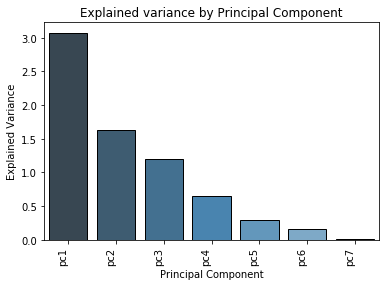

In [22]:
# Plot the explained variance for all principal components.
ax = sns.barplot(x=X_train_PCA.columns[:], y=pca.explained_variance_, palette="Blues_d")
ax.title.set_text('Explained variance by Principal Component');
ax.set(xlabel='Principal Component', ylabel='Explained Variance')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right');

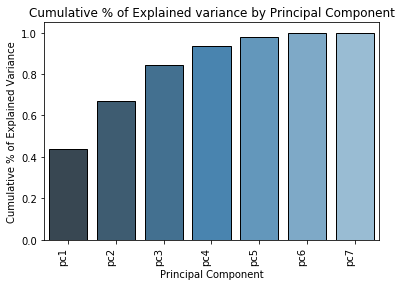

In [23]:
# Plot as a percentage of the explained variance
ax = sns.barplot(
        x=X_train_PCA.columns[:], 
        y=np.cumsum(pca.explained_variance_) / pca.explained_variance_.sum(),
        palette="Blues_d")
ax.title.set_text('Cumulative % of Explained variance by Principal Component');
ax.set(xlabel='Principal Component', ylabel='Cumulative % of Explained Variance')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right');

#### keep first 4 PCA components

In [24]:
n_components = 4

X_train_PCA = X_train_PCA.iloc[:,:n_components]
X_test_PCA = X_test_PCA.iloc[:,:n_components]
pca_cols = pca_cols[:n_components]

#### Combine categorical, ordinal, continuous, and binary columns into prepped datasets

In [25]:
# prepped training dataset
X_train_featurized = X_train_onehot # add one-hot-encoded columns
X_train_featurized[pca_cols] = X_train_PCA # add PCA components (continuous columns)
X_train_featurized[ordinal_cols] = X_train_norm[ordinal_cols] # add ordinal columns
X_train_featurized[binary_cols] = X_train_binary # add binary columns

# prepped test dataset
X_test_featurized = X_test_onehot # add one-hot-encoded columns
X_test_featurized[pca_cols] = X_test_PCA # add PCA components (continuous columns)
X_test_featurized[ordinal_cols] = X_test_norm[ordinal_cols] # add ordinal columns
X_test_featurized[binary_cols] = X_test_binary # add binary columns

#### combine target and features back together to fit model

- exhaustively specifying features & target in the formula is a requirement of patsy via sm.ols

In [26]:
# combine training data
train = X_train_featurized.copy()
train['y'] = y_train

# combine test data
test = X_test_featurized.copy()
test['y'] = y_test

In [27]:
# Set linear regression formula.
formula_target = 'y ~ '
formula_features = " + ".join(X_train_featurized.columns)
formula_final = formula_target + formula_features

#### fit regression & make predictions

In [28]:
# initialize & fit model
ols_model = smf.ols(formula = formula_final, data = train)
ols_model = ols_model.fit()

# make predictions
train_pred = ols_model.predict(X_train_featurized)
test_pred = ols_model.predict(X_test_featurized)

#### calculate RMSE

In [29]:
# calculate RMSE of log transformed price
rmse_train = mean_squared_error(y_train, train_pred, squared = False) # obtain RMSE
rmse_test = mean_squared_error(y_test, test_pred, squared = False) # obtain RMSE

# also calculate RMSE of original price (for interpretability)
rmse_test_exp = mean_squared_error(np.exp(y_test), np.exp(test_pred), squared = False) # obtain RMSE

### model summary:

test rmse = 0.284 (on log transformation) >> $184,000 on untransformed price

Ajusted r-squared = 0.705

Many of our predictors did in fact have statistically significant coefficients. In fact the only ones that *weren't* significant were:
- floors = 2
- floors = 3.5
- first 4 of zip code: (9806-, 9807-, 9814-, 9815-, 9819-)

Also worth noting that train rmse is about the same as test rmse.  Unlikely that we've over-fitted.

In [30]:
# print rmse
print('rmse - train (log):', round(rmse_train, 3))
print('rmse - test (log):', round(rmse_test, 3))
print('rmse - test :', round(rmse_test_exp, -3))

rmse - train (log): 0.286
rmse - test (log): 0.284
rmse - test : 184000.0


In [31]:
# show model summary (0.657)
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     1216.
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:45:02   Log-Likelihood:                -2861.2
No. Observations:               17284   AIC:                             5792.
Df Residuals:                   17249   BIC:                             6064.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       13.0225      0.007   1825.636   

### binarize predictions

- set home price threshold at \\$450K

In [32]:
# import accuracy calculation packages
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [33]:
# set binary home sale price threshold
threshold = 450000

# binarize train & test data (0 = <$450K. 1 = $450K+)
y_train_bin = (y_train >= np.log(threshold)).astype(int)
y_test_bin = (y_test >= np.log(threshold)).astype(int)

#### define model accuracy summary functions

In [34]:
# function to calculate & present accuracy metrics (f1, precision, recall, accuracy)
def model_accuracy(y, y_hat, model_name):
    
    # calculate accuracy metrics
    f1 = f1_score(y, y_hat, pos_label = 1)
    precision = precision_score(y, y_hat, pos_label = 1)
    recall = recall_score(y, y_hat, pos_label = 1)
    accuracy = accuracy_score(y, y_hat)
    
    # print output
    print(model_name)
    print('-------------------')
    print("f1:         ", round(f1,3))
    print("precision:  ", round(precision,3))
    print("recall:     ", round(recall,3))
    print("accuracy:   ", round(accuracy,3))
    print("\n==================================\n")

And also define a function to more clearly visualize our resulting confusion matrix.

In [35]:
# function to make confusion matrix a bit more readable
def c_matrix(y, y_hat, title, labels):

    # normalize confusion matrix
    cm = confusion_matrix(y, y_hat, normalize = "pred")

    # configure confusion matrix plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # show plot and confusion matrix
    plt.show()
    print(cm)

### model accuracy = 80.5% using OLS with threshold at \\$450K

In [36]:
# binarize ols predictions & examine model accuracy
test_pred_bin = (test_pred > np.log(threshold)).astype(int)
model_accuracy(y_test_bin, test_pred_bin, 'ols')

ols
-------------------
f1:          0.795
precision:   0.82
recall:      0.772
accuracy:    0.803




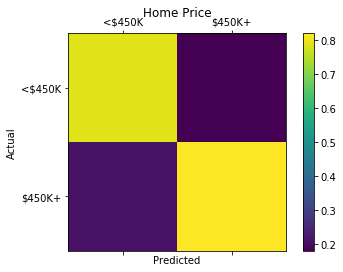

[[0.78874459 0.17992048]
 [0.21125541 0.82007952]]


In [37]:
c_matrix(y_test_bin, test_pred_bin, "Home Price", ['<$450K', '$450K+'])

### quick comparison to knn (just for fun)

In [38]:
from sklearn.neighbors import KNeighborsClassifier

In [39]:
# fit model
knnb = KNeighborsClassifier(n_neighbors = 20)
knnb.fit(X_train_featurized, y_train_bin)

# make predictions
y_hat_knn = pd.DataFrame(
    knnb.predict_proba(X_test_featurized)[:,1] >= 0.5, 
    columns = ['y_hat']).astype('int')

#### examine model accuracy

- overall a bit better than ols, although has a bit harder time identifying the expensive houses (79.8% accuracy vs 81.2% accuracy with OLS)

In [40]:
model_accuracy(y_test_bin, y_hat_knn, 'knn')

knn
-------------------
f1:          0.82
precision:   0.8
recall:      0.84
accuracy:    0.817




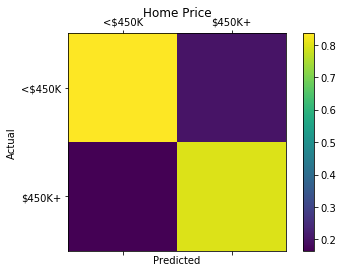

[[0.83533943 0.2       ]
 [0.16466057 0.8       ]]


In [41]:
c_matrix(y_test_bin, y_hat_knn, "Home Price", ['<$450K', '$450K+'])

## Conclusion

Many features had predictive power in determining a home's sale price.

We were able to achieve an R-squared of ~0.70 on our test data using OLS to predict a home's price.  After binarizing the data, we were able to classify with overall accuracy of ~80%; both with our linear model and our k-nearest neighbors (knn) model.